<a href="https://colab.research.google.com/github/MarshaGomez/F5-MOEA-Variations/blob/main/examples/Multi_Objective_Brachistochrone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi Objective. Brachistochrone Problem


The Brachistochone is the famous problem to find the shape of the curve down wich a bead sliding from rest and accelerated by gravity will slip (**without friction**) from one point to another in the least time. 

"The shortest path and the shortest time"

## Base Operations

### Necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import random as rm
import os
import subprocess
import torch
import sys
import torch.optim as optim
import glob
import time
import pickle
import json
import base64
import csv
import operator
  
from IPython import display
from pathlib import Path
from PIL import Image, ImageSequence
from time import sleep
from datetime import datetime, date
from math import sqrt,sin,cos, floor
from scipy.optimize import fsolve
from random import shuffle, randint, sample
from copy import deepcopy

### Hyperparameters

In [45]:
ga_selection_method = ["Tournament", "NSGA2"]
ga_objectives = ["Time", "Distance"]
ga_n_dimensions = 2
ga_n_individuals = 50
ga_n_generations = 10000
ga_n_points = 15

# Probabilities
ga_ps = 0.7 # selection
ga_pc = 1 # crossover
ga_pm = 0.3 # mutation Change less mutation

ga_elitismo = 0.1 

ga_p_variable = True # Varied the probability

# Boundaries 
ga_xl = 0 # left boundary
ga_xr = 1 # rigth boundary
ga_yu = 1 # up boundary
ga_yl = -1 # low boundary
ga_limits = [ga_xl, ga_yl]
ga_weights = [0.6, 0.4] # Time, Distance
ga_height = 1
ga_width = 1

ga_seed = 1

ga_show_info = True # See Important Info
ga_show_debug = False # See Specific info to help the visualization for develop
ga_show_plot = True # See Description Prints
ga_save_gif = True # Save gif image
ga_frames_gif = 100
ga_parents = []
ga_new_individuals = []

ga_base_path = "/content/gdrive/My Drive/Brachistochrone/MOEA Project/Multi-Objective"
ga_counter = 0
ga_misc_runs_dir = ""
ga_evolution_dir = ""
ga_objectives_dir = ""

date_string = date.today()
base_name = f'Env_({date_string})_n-ind={ga_n_individuals}_ps={ga_ps}_pc={ga_pc}_pm={ga_pm}'

### Common Functions

In [4]:
def normalize(data, min, max):
  normal = []
  old_min = np.min(data)
  old_max = np.max(data)
  old_range = old_max - old_min
  
  new_min = min
  new_max = max
  new_range = new_max - new_min

  if old_range == 0:            
      if old_min < new_min:      
          new_value = new_min
      elif old_min > new_max:    
          new_value = new_max
      else:                    
          new_value = old_min
      normal = [new_value for value in data]
  else:
      scale = new_range / old_range
      normal = [(value - old_min) * scale + new_min for value in data]

  return normal

def fitnessFunction(y_no_end_pts, height):
  g = 9.8
  n_segments = len(y_no_end_pts) + 1
  width = 1.0
  delta_x = width/n_segments
  #So if the next point is lower than the previous one, d will be *positive* (i.e., the y axis is down, opposite with the plot axis.)

  y = torch.cat((torch.tensor([height]), y_no_end_pts, torch.tensor([0.0])), dim=0)

  d = torch.stack([-(y[i+1] - y[i]) for i in range(n_segments)])

  temp = torch.stack([torch.tensor(0.0)] + [sum(d[:(i+1)]) for i in range(len(d))])
  v = sqrt(2*g)*torch.sqrt(temp)

  v = v[:-1]
  t = (torch.sqrt(v**2 + 2*g*d) - v)/(g*d/torch.sqrt(d**2 + delta_x**2))

  return(sum(t))

def exportCSV(data, folder=ga_misc_runs_dir, file='data.csv'):
  file = os.path.join(folder, file)

  if not Path(file).is_file():
    with open(file, 'w', encoding='UTF8', newline='') as f:
      writer = csv.writer(f)
      writer.writerows(data) # Write multiple rows

def importCSV(folder=ga_misc_runs_dir, file='data.csv'):
  file = os.path.join(folder, file)
  list_points = []

  if Path(file).is_file():
    with open(file, 'r') as f:
      csv_reader = csv.reader(f)
      for line in csv_reader:
        list_points.append(list(line))

  return list_points

def exportGIF(fp_in, fp_out):
  global ga_counter
  ga_counter += 1

  imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
  img = next(imgs)  # extract first image from iterator
  img.save(fp=fp_out, format='GIF', append_images=imgs,
          save_all=True, duration=400, loop=0)
  
  img = Image.open(fp_out)
  
def showGIF(folder=ga_misc_runs_dir):

  file = os.path.join(folder, 'gif.gif')

  with open(file, 'rb') as fd:
      b64 = base64.b64encode(fd.read()).decode('ascii')
  return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

def makeFolders():
  global date_string, base_name, ga_evolution_dir, ga_objective_dir, ga_misc_runs_dir

  date_string = date.today()
  base_name = f'Env_({date_string})_n-ind={ga_n_individuals}_ps={ga_ps}_pc={ga_pc}_pm={ga_pm}'
  ga_evolution_dir = os.path.join(ga_base_path, "evolution/" + base_name)
  ga_objective_dir = os.path.join(ga_base_path, "objectives/" + base_name)
  ga_misc_runs_dir = os.path.join(ga_base_path, "misc_runs/" + base_name)

  Path(ga_evolution_dir).mkdir(parents=True, exist_ok=True)
  Path(ga_objective_dir).mkdir(parents=True, exist_ok=True)
  Path(ga_misc_runs_dir).mkdir(parents=True, exist_ok=True)

# set_global = False as default, If you want to use the new config from file = True
# If you want to save the new configuration but don't update the global values = False
def initConfig(folder=ga_misc_runs_dir, file='config.json', set_global=False):
  file = os.path.join(folder, file)

  if Path(file).is_file():
    with open(file, "r") as jsonfile:
      myJSON = json.loads(jsonfile.read()) # Reading from file
  else:
    globals__ = globals()
    config = {}

    # Inside our Genetic algorithm, we declare all global values as ga_*
    # Easier for search and get all the config values
    for key, value in sorted(globals__.items()):
      if key.startswith('ga_'):
        config[key] = value

    myJSON = json.dumps(config, indent = 4) 

    with open(file, "w") as jsonfile:
        jsonfile.write(myJSON)

  if ga_show_debug:
    print("\n--------------------------------")
    print(f'Configuration: \n{file}')
    print(myJSON)
    print("Write successful")
    print("--------------------------------\n")

  if set_global:
    globals().update(myJSON)
  

## Genetic Algorithm Components



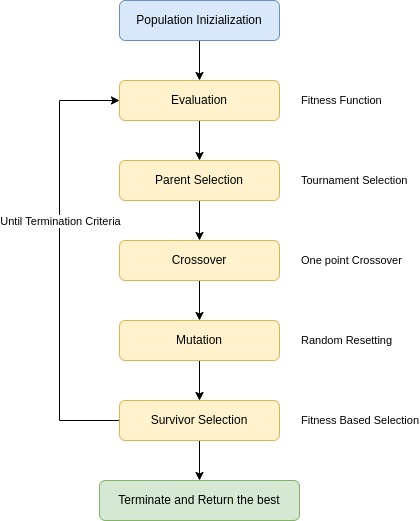

### Initialization


#### Individual

Creating Random Individual

In [5]:
class Individual():

  def __init__(self, 
               n_points=ga_n_points, 
               height=ga_height,
               width=ga_width,
               x=[],
               y=[], 
               random=True):

    self.n_points = n_points
    self.n_segments = n_points-1
    self.width = width
    self.height = height
    self.x = x
    self.y = y

    if random:
      self.generateIndividual()

  def generateIndividual(self):
    self.y = [self.height]
    self.x = [0]
    self.delta_x = self.width/self.n_segments

    for i in range(self.n_segments-1):
        self.x.append((i+1)*self.delta_x)
        frac = 1
        self.y.append(-self.height/frac + rm.random()*(self.height - (-self.height/frac)))

    self.x.append(self.width)
    self.y.append(0)


#### Population

Creating a Population with n-random Individuals

In [24]:
class Population():
  
  def __init__(self, 
              individual=Individual, 
              n_individuals=ga_n_individuals,
              objectives=ga_objectives,
              show_plot=False, 
              show_info=False, 
              show_debug=False, 
              **kwargs):
    
    self.kwargs_str = '__'.join(['{}={}'.format(x[0], x[1]) for x in kwargs.items()])
    self.individual = individual
    self.class_name = individual.__name__
    self.n_individuals = n_individuals
    self.objectives = objectives
    self.show_plot = show_plot
    self.show_info = show_info
    self.show_debug = show_debug
    
    self.fitness_values = np.zeros((self.n_individuals, len(self.objectives))) # Because of 2 objective functions

    # If automatic generation of individuals, random = True
    self.random = kwargs.get('random', True)
    
    if self.random:
      self.list_individuals = [[self.createNewIndivid(**kwargs),0] for i in range(self.n_individuals)]
    else:
      self.list_individuals = [[self.setNewIndivid(i, **kwargs),0] for i in range(self.n_individuals)]

    if self.show_plot:
      # Initialise the subplot function using number of rows and columns
      figure, ax = plt.subplots(1,1,  figsize=(5,4))
      self.plotPopulation(ax)
      plt.show()

    if self.show_info:
      self.printPopulation()

  def createNewIndivid(self, **kwargs):
    return(self.individual(**kwargs))

  def setNewIndivid(self, index, **kwargs):
    list_points = kwargs.get('list_points', [])
    n_points = kwargs.get('n_points', 0)
    height = kwargs.get('height', ga_height)
    width = kwargs.get('width', ga_width)

    if (len(list_points) > 0) and (len(list_points) > index):
      x = list_points[index][0]
      y = list_points[index][1]

      if (n_points == 0):
        n_points = len(x)
        
      return(self.individual(n_points=n_points,
                             height=height, 
                             width=width,
                             x=x, 
                             y=y,
                             random=self.random))
    else:
      return(self.individual())

  def printPopulation(self):
    print("\n--------------------------------")
    print("Population Created")
    print("--------------------------------")
    print("Number of individuals: ", str(self.n_individuals))
    print("Population Edited Parameters: ", str(self.kwargs_str))
    print("-------------------------------- \n")


  def plotPopulation(self, ax, **kwargs):
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_title('Population Representation')

    for individual in self.list_individuals:
      ax.plot(individual[0].x, individual[0].y)



  

### Evaluation

In [7]:
class Fitness():

  global show_info

  def __init__(self, 
              population=Population, 
              weights=ga_weights,
              objectives=ga_objectives,
              selection_method=ga_selection_method[0],
              show_plot=False, 
              show_info=False, 
              show_debug=False):
    
    self.population = population
    self.weights = weights
    self.objectives = objectives,
    self.show_plot = show_plot
    self.show_info = show_info
    self.show_debug = show_debug

    self.t_ideal = 0
    self.sol = []

    individual = self.population.list_individuals[0][0]
    self.maxTime = self.getMaxTime(individual)
    self.maxDistance = self.getMaxDistance(individual)
    self.getBestCurve(individual)

  '''
  def __del__(self):
    del self.population
    # print("Destructor called")
  '''

  def setPopulation(self, population):
    self.population = population

  def getBestCurve(self, individual):
    w = individual.width
    h = individual.height

    #The coords we've been using (dropped at (0,h), ending at (w,0)), simply add h to y in the end.

    f_t = lambda t: np.cos(t)-1+ (-h/w)*(np.sin(t)-t)
    t = fsolve(f_t,3.14)[0]

    a = w/(t-sin(t))

    t_range = np.linspace(0,t,individual.n_points)

    x = lambda t: a*(t-np.sin(t))
    y = lambda t: h + a*(np.cos(t)-1)

    self.sol = (t_range, x, y)

    sol_numeric_y = []

    for x_pt in individual.x:
        f = lambda t: x(t)-x_pt
        tval = fsolve(f,3.14)[0]
        sol_numeric_y.append(y(tval))

    temp_state = individual.y
    individual.y = sol_numeric_y
    individual.sol_numeric_y = sol_numeric_y
    
    self.t_ideal = self.getFitness(individual)
    individual.y = temp_state

    if self.show_info:
      print('\n-------------------------------------')
      print('Theoretical best time:', self.t_ideal, "\n")

  def getObjectives(self, individual):
    g = 9.8
    v = [0]
    t = []
    l = []

    for i in range(len(individual.y)-1):
      v.append(sqrt(2*g*(individual.y[i] - individual.y[i+1])+v[i]**2))
      l.append(sqrt((individual.x[i] - individual.x[i+1])**2 + (individual.y[i] - individual.y[i+1])**2))
      t.append(l[i] / v[i+1])

    ## F1 = self.weights[0]*sum(t) # Time
    ## F2 = self.weights[1]*sum(l) # Distance
    
    F1 = self.weights[0]*sum(t) # Time
    F2 = self.weights[1]*sum(l) # Distance

    return F1, F2

  def getFitness(self, individual):
    F1, F2 = self.getObjectives(individual)

    return F1 + F2

  def getFitnessPopulation(self, sort=False):
    for individual in self.population.list_individuals:
      individual[1] = self.getFitness(individual[0])
      self.population.fitness_values[0], self.population.fitness_values[1] = self.getObjectives(individual[0])

    if sort:
      self.sortIndividuals()

    if self.show_info:
      self.printFitnessFunctions()

    return self.population

  def sortIndividuals(self):
    list.sort(self.population.list_individuals, key=lambda fitness: fitness[1])

  def getMaxTime(self, individual):
    maxTime = sqrt((individual.x[0] - individual.x[-1])**2 + (individual.y[0] - individual.y[-1])**2)

    return maxTime

  def getMaxDistance(self, individual):
    maxDistance = (individual.x[-1] - individual.x[0]) + (individual.y[0] - individual.y[-1])
    maxDistance *= individual.n_points

    return maxDistance

  def printFitnessFunctions(self):
    print('\n-------------------------------------')
    print('Objective Fitness 1: ', self.objectives[0])
    print('\n')
    for index, individual in enumerate(self.population.list_individuals):
      print('Individual {:10}     |    W. Fitness: {:.4f}'.format(index, individual[1]))

  def plotState(self, individual, ax, width, height, color='black', plot_sol=False, plot_label=False):
    ax.clear()
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_title('Comparison Actual Result with Brachistochrone')

    if plot_sol:
      t = self.sol[0]
      x = self.sol[1]
      y = self.sol[2]
      ax.plot(x(t), y(t), '-', color='gray')

      if plot_label:
        ax.text(0.8*width, 0.9*height, 'ideal: {:.3f}'.format(self.t_ideal))

    if plot_label:
      ax.text(0.8*width, 0.8*height, 'cur. best: {:.3f}'.format(self.getFitness(individual)))

    ax.plot(individual.x, individual.y, 'o-', color=color)


  def plotFitnessFunction(self, ax, best, mean):
    ax.set_xlabel('Generations')
    ax.set_ylabel('Fitness Function')
    ax.set_title('Best and Mean Results')

    ax.plot(best, label='best', color='dodgerblue')
    ax.plot(mean, label='mean', color='tomato')
    ax.legend()
    ax.text(0.6*len(best), 0.8*max(best), 'best: {:.3f}\nmean: {:.3f}'.format(best[-1], mean[-1]))


### Selection

In [8]:
class Selection():
  
  def __init__(self,
               population=Population, 
               ps=ga_ps,
               show_plot=False,
               show_info=False, 
               show_debug=False):
    
    self.population = population
    self.parents = []
    self.ps = ps
    self.quantity_parents = 3

    self.show_plot = show_plot
    self.show_info = show_info
    self.show_debug = show_debug

  '''
  def __del__(self):
    del self.population
    del self.parents

   #    print("Destructor called")
  '''

  # Probabilistic Selection
  def getProbabilisticSelection(self):
    probability = np.random.uniform(
        low=0, high=1, size=self.population.n_individuals)
    
    probability = probability <= self.ps
    if sum(probability == True) > 0:
      self.quantity_parents = sum(probability == True)

  def getParentsSelection(self):
    self.getProbabilisticSelection()
    for i in range(self.quantity_parents):
      self.parents.append(self.tournamentSelection())

    # self.parents = np.unique(self.parents, axis=0)

    if self.show_info:
      self.printParents()

    return self.parents

  def tournamentSelection(self):
    parents = rm.choices(self.population.list_individuals, k=5)
    list.sort(parents, key=lambda fitness: fitness[1])

    return (parents[0])

  def printParents(self):
    print('\n-------------------------------------')
    print('Selection Parents')
    print('\n')
    for index, individual in enumerate(self.parents):
      print('Individual {:10}     |    Fitness: {:.4f}'.format(index, individual[1]))

  def isSameState(self, other_state):
    max_diff = ((self.n_points-2)*self.height)**2
    diff = (np.array(self.y) - np.array(other_state.y))[1:-1]
    abs_diff_normed = abs(sum(diff))/(self.n_points-2)
    
    if abs_diff_normed < self.sameness_thresh:
      return(True)
    else:
      return(False)

  def deleteDuplicates(self,pop):
    unique_individuals = []
    no_duplicates = []
    
    for index,individual in enumerate(pop):
      is_not_unique = np.any([individual.isSameState(other) for other in no_duplicates])
      if not is_not_unique:
        unique_individuals.append(individual.y)
        no_duplicates.append(individual)

    return(no_duplicates)

### Crossover

In [9]:
class Crossover():
  
  def __init__(self, 
               population=Population, 
               parents=ga_parents, 
               pc=ga_pc,
               show_plot=False, 
               show_info=False, 
               show_debug=False):
 
    self.population = population
    self.parents = parents
    self.new_individuals = []
    self.pc = pc

    self.show_plot = show_plot
    self.show_info = show_info
    self.show_debug = show_debug

  '''
  def __del__(self):
    del self.population
    del self.parents
    del self.new_individuals

    #print("Destructor called")
  '''

  def getNewIndividuals(self):
    rm.shuffle(self.parents)
    n_couple = int((len(self.parents)-1) / 2)
    for i in range(n_couple+1):
      new_child1, new_child2 = self.onePointCrossover(self.parents[i], self.parents[-(i-1)])
      self.new_individuals.append(new_child1)
      self.new_individuals.append(new_child2)

    if self.show_info:
      self.printNewPopulation()

    return self.new_individuals

  def onePointCrossover(self, parent1, parent2):
    new_child1 = deepcopy(parent1)
    new_child2 = deepcopy(parent2)

    r1 = randint(1,parent1[0].n_points-3)
    r2 = randint(r1+1,parent2[0].n_points-2)

    temp = new_child1[0].y[r1:r2]
    new_child1[0].y[r1:r2] = new_child2[0].y[r1:r2]
    new_child2[0].y[r1:r2] = temp

    return(new_child1, new_child2)


  def printNewPopulation(self):
    print('\n-------------------------------------')
    print('Crossover New Individuals')
    print('\n')
    for index, individual in enumerate(self.new_individuals):
      print('Individual {:10}     |    Individual Y:'.format(index), *individual[0].y, sep=', ')


  def mateAvg(self,other_individ):
    newindivid_1 = deepcopy(self)
    newindivid_2 = deepcopy(other_individ)

    newindivid_1.y = ((np.array(newindivid_1.y) + np.array(newindivid_2.y))/2).tolist()

    return(newindivid_1,newindivid_1)

### Mutation

In [10]:
class Mutation():

  def __init__(self, 
               new_individuals=ga_new_individuals, 
               pm=ga_pm,
               show_plot=False, 
               show_info=False, 
               show_debug=False):
    
    self.new_individuals = new_individuals
    self.pm = pm

    self.show_plot = show_plot
    self.show_info = show_info
    self.show_debug = show_debug

  '''
  def __del__(self):
    del self.new_individuals

    # print("Destructor called")
  '''

  def randomSetMutation(self):
    mutate_individual = []
    mutate_individual.clear()

    for individual in self.new_individuals:
      mutate_individual.append(self.mutate(individual))

    self.new_individuals = mutate_individual
      
    if self.show_info:
      self.printMutation()

    return self.new_individuals

  def mutate(self, individual):
    probability = np.random.uniform(
    low=0, high=1, size=individual[0].n_points-2)

    probability = probability <= self.pm

    mutate_individual = deepcopy(individual)
    height = individual[0].height
  
    if sum(probability == True) > 0:
      mutate_individual[0].y = mutate_individual[0].y[1: mutate_individual[0].n_points-1]

      # Muta Random Process
      for i in np.where(probability)[0]:
        frac = 2
        mutate_individual[0].y[i] = (-height/frac + rm.random()*(height - (-height/frac)))
      
      mutate_individual[0].y = [height] + mutate_individual[0].y + [0]

    return mutate_individual 

  def printMutation(self):
    print('\n-------------------------------------')
    print('Mutation New Individuals')
    print('\n')
    for index, individual in enumerate(self.new_individuals):
      print('Individual {:10}     |    Individual Y:'.format(index), *individual[0].y, sep=', ')

  def mutateSingle(self):
    index = randint(1, self.n_segments-1)
    new_height = self.y[index] + np.random.normal(scale=self.mutate_strength)
    
    if new_height < self.height:
      self.y[index] = new_height

### Survivor Selection

In [26]:
class Survivor_Selection():
  def __init__(self, 
               population=Population, 
               new_individuals=ga_new_individuals,
               objectives=ga_objectives,
               show_plot=False, 
               show_info=False, 
               show_debug=False):
    
    self.population = population
    self.new_individuals = new_individuals
    self.objectives = objectives
    self.show_plot = show_plot
    self.show_info = show_info
    self.show_debug = show_debug

    self.new_population = []

  '''
  def __del__(self):
    del self.population 
    del self.new_individuals 
    del self.new_population
    # print("Destructor called")
  '''

  def getNewPopulation(self):
    fitness = Fitness(self.population)

    self.new_population =  self.population.list_individuals + self.new_individuals
    fitness_values = np.zeros((len(self.new_population), len(self.objectives)))

    for i, individual in enumerate(self.new_population):
      fitness_values[i][0], fitness_values[i][1] = fitness.getObjectives(individual[0])
    
    pareto_front_index = []
    pop_index_0 = np.arange((len(self.new_population)))
    pop_index = np.arange((len(self.new_population)))

    while len(pareto_front_index) < self.population.n_individuals:

      new_pareto_front = self.paretoFront(fitness_values[pop_index_0, :], pop_index_0)
      total_pareto_size = len(pareto_front_index) + len(new_pareto_front)

      if total_pareto_size > self.population.n_individuals:
        number_solutions_needed = self.population.n_individuals - len(pareto_front_index)
        selected_population_index = self.removeWithCrowding(fitness_values[new_pareto_front], number_solutions_needed)
        new_pareto_front = new_pareto_front[selected_population_index]
    
      pareto_front_index = np.hstack((pareto_front_index, new_pareto_front))
      remaining_index = set(pop_index) - set(pareto_front_index)
      pop_index_0 = np.array(list(remaining_index))

    selected_population_index = [pareto_front_index.astype(int)][0]
    
    self.new_population = [self.new_population[i] for i in selected_population_index]
    
    self.population.list_individuals = self.new_population
    
    fitness.setPopulation(self.population)
    fitness.getFitnessPopulation()

    self.population = fitness.population

    self.best, self.mean = self.getBestandMean()

    if self.show_info:
      self.printSurvivor()

    if self.show_plot:
      plt = self.plotParetoFront(fitness_values)
      plt.show()

    for i, individual in enumerate(self.population.list_individuals):
      self.population.fitness_values[i][0], self.population.fitness_values[i][1] = fitness.getObjectives(individual[0])

    return self.population

  def crowdingCalculation(self, fitness_values):
    population_size = len(fitness_values[:, 0])
    dimension = len(fitness_values[0, :])
    crowding = np.zeros((population_size, dimension))

    normalize_fitness_values = (fitness_values - fitness_values.min(0))/fitness_values.ptp(0)

    for i in range(dimension):
      crowding_results = np.zeros(population_size)
      crowding_results[0] = 1
      crowding_results[population_size - 1] = 1
      sorting_normalize_fitness_values = np.sort(normalize_fitness_values[:, i])
      sorting_normalized_values_index = np.argsort(normalize_fitness_values[:, i])

      # Crowding Distance Calculation
      crowding_results[1:population_size-1] = (sorting_normalize_fitness_values[2:population_size] - sorting_normalized_values_index[2:population_size])
      re_sorting = np.argsort(sorting_normalized_values_index)
      crowding[:,i] = crowding_results[re_sorting]

    crowding_distance = np.sum(crowding, axis=1) # crowding distance of each solution
    
    return crowding_distance


  def removeWithCrowding(self, fitness_values, number_solutions_needed):
    population_index = np.arange(fitness_values.shape[0])
    crowding_distance = self.crowdingCalculation(fitness_values)
    selected_population_index = np.zeros((number_solutions_needed))
    selected_fitness_values = np.zeros((number_solutions_needed, len(fitness_values[0, :])))

    for i in range(number_solutions_needed):
      population_size = population_index.shape[0]
      a = rm.randint(0, population_size - 1) # Solution Random 1
      b = rm.randint(0, population_size - 1) # Solution Random 2
      if crowding_distance[a] >= crowding_distance[b]:
        # Solution 1 is better than solution 2
        selected_population_index[i] = population_index[a]
        selected_fitness_values[i, :] = fitness_values[a, :]
        population_index = np.delete(population_index, (a), axis=0)
        fitness_values = np.delete(fitness_values, (a), axis=0)
        crowding_distance = np.delete(crowding_distance, (a), axis=0)

      else:
        # Solution 2 is better than solution 1
        selected_population_index[i] = population_index[b]
        selected_fitness_values[i, :] = fitness_values[b, :]
        population_index = np.delete(population_index, (b), axis=0)
        fitness_values = np.delete(fitness_values, (b), axis=0)
        crowding_distance = np.delete(crowding_distance, (b), axis=0)
    
    selected_population_index = np.asarray(selected_population_index, dtype=int) # Convert the data to integer 
     
    return selected_population_index

  def paretoFront(self, fitness_values, population_index):
    population_size = fitness_values.shape[0]
    # Initially assume all solutions are in pareto front by using "1"
    pareto_front = np.ones(population_size, dtype=bool) 
    for i in range(population_size):
        for j in range(population_size):
                if all(fitness_values[j] <= fitness_values[i]) and any(fitness_values[j] < fitness_values[i]):
                  pareto_front[i] = 0
                  break
    return population_index[pareto_front]

  def plotParetoFront(self, ax, fitness_values, maxX=False, maxY=False):
    ax.set_xlabel(self.objectives[0])
    ax.set_ylabel(self.objectives[1])
    ax.set_title('Pareto Frontier')

    # Pareto frontier selection process
    self.time = [fitness[0] for fitness in fitness_values]
    self.distance = [fitness[1] for fitness in fitness_values]

    sorted_list = sorted([[self.time[i], self.distance[i]] for i in range(len(self.time))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)

    '''Plotting process'''
    ax.scatter(self.time, self.distance)
    x = [pair[0] for pair in pareto_front]
    y = [pair[1] for pair in pareto_front]
    
    ax.plot(x, y)
    

  def getBestandMean(self):
    best = self.population.list_individuals[0][1]
    mean = sum([individual[1] for individual in self.population.list_individuals])/(1.0*len(self.population.list_individuals))
    return((best,mean))

  def printSurvivor(self):
    print('\n-------------------------------------')
    print('Objective Fitness 1: ', self.objectives[0])
    print('\n')
    for index, individual in enumerate(self.population.list_individuals):
      print('Individual {:10}     |    Fitness: {:.4f}'.format(index, individual[1]))



## Genetic Algorithm execution

In [43]:
class GeneticAlgorithm():

  # Variable = Variation of the Probability between epochs
  def __init__(self, 
               population=Population, 
               n_generations=ga_n_generations,
               objectives=ga_objectives,
               selection_method=ga_selection_method[0],
               misc_runs_dir=ga_misc_runs_dir,
               evolution_dir=ga_evolution_dir,
               objectives_dir=ga_objectives_dir,
               ps=ga_ps, 
               pc=ga_pc, 
               pm=ga_pm,
               save_gif=True,
               show_plot=False, 
               show_info=False, 
               show_debug=False):   

    self.population = population
    self.n_generations = n_generations
    self.objectives = objectives
    self.selection_method = selection_method
    self.misc_runs_dir = misc_runs_dir
    self.evolution_dir = evolution_dir
    self.objectives_dir = objectives_dir
    self.ps = ps 
    self.pc = pc 
    self.pm = pm
    self.save_gif = save_gif,
    self.show_plot = show_plot, 
    self.show_info = show_info, 
    self.show_debug = show_debug
    
    self.parents = []
    self.new_individuals = []

    best = []
    mean = []

    gif_counter = 0
    
    # Preparation of environment folders 
    makeFolders()
    initConfig(folder=self.misc_runs_dir, set_global=False)

    start = time.time()

    for i in range(self.n_generations):
      fitness = Fitness(self.population)
      self.population = fitness.getFitnessPopulation()
      selection = Selection(self.population, self.ps)
      self.parents = selection.getParentsSelection()
      crossover = Crossover(self.population, self.parents, self.pc)
      self.new_individuals = crossover.getNewIndividuals()
      mutation = Mutation(self.new_individuals, self.pm)
      self.new_individuals = mutation.randomSetMutation()
      survivor_selection = Survivor_Selection(self.population, self.new_individuals)
      self.population = survivor_selection.getNewPopulation()

      best.append(survivor_selection.best)
      mean.append(survivor_selection.mean)

      if self.show_info:
        if i%max(1, int(self.n_generations/20.0))==0:
          print('Generation {}, current best = {:.3f}, current population size = {}'.format(i, survivor_selection.best, len(self.population.list_individuals)))
          
    if self.show_plot:
      individual = self.population.list_individuals[0][0]

      # Initialise the subplot function using number of rows=2 and columns=2
      figure, ax = plt.subplots(2, 2, figsize=(15,13))
      plt.subplots_adjust(left=0.1,
                  bottom=0.1, 
                  right=0.9, 
                  top=0.9, 
                  wspace=0.4, 
                  hspace=0.4)
        
      # Population Representation
      self.population.plotPopulation(ax[0, 0])
        
      # Pareto Function
      survivor_selection.plotParetoFront(ax[0, 1], self.population.fitness_values)

      # Fitness Function
      fitness.plotFitnessFunction(ax[1, 0], best, mean)

      # Best Function
      fitness.plotState(individual, ax[1, 1], individual.width, individual.height, color='tomato', plot_sol=True, plot_label=True)

      # Combine all the operations and display
      figure.canvas.draw()

      plt.savefig(f'{self.misc_runs_dir}/best.png')
      
    end = time.time()

    print('\n-------------------------------------')
    print("Process Complete")
    print('-------------------------------------\n')
    print("Object Fitness:", *self.objectives, sep=', ')
    print("Number of Generations", self.n_generations)
    print("Best Result", survivor_selection.best)
    print("Ideal Result", fitness.t_ideal)
    print("Time Process: {:20}".format(str(end - start)))
    print("\n-------------------------------------------\n")

    
    

# Test Section

## Individual Random Generation

In [13]:
'''
population = Population(Individual, 
                        ga_n_individuals, 
                        n_points=ga_n_points, 
                        height=ga_height, 
                        show_plot=ga_show_plot, 
                        show_info=ga_show_info, 
                        show_debug=ga_show_debug)


individual = population.list_individuals[0][0]

fitness = Fitness(population)
fitness.getBestCurve(individual)


y = torch.tensor(individual.y[1:-1], requires_grad=True)

adam_optimizer = optim.RMSprop([y])

best = []
mean = []

for t in range(ga_n_generations):

    J = fitnessFunction(y, ga_height)

    best.append(J.item())
    mean.append(np.mean(best))

    individual.y[1:-1] = y.detach().tolist()

    if ga_show_info:
      if t%int(ga_n_generations/20)==0:
        print('iteration {:10}     |    loss: {:.4f}'.format(t, J.item()))

    adam_optimizer.zero_grad()
    J.backward()
    adam_optimizer.step()

if ga_show_plot:
  print('\n-------------------------------------')

  fig, axes = plt.subplots(2,1,figsize=(6,8))
  plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
  ax_FF = axes[0]
  ax_state = axes[1]
  fitness.plotFitnessFunction(ax_FF, best, mean)
  fitness.plotState(individual, ax_state, ga_width, ga_height, color='tomato', plot_sol=True, plot_label=True)

  fig.canvas.draw()
'''

"\npopulation = Population(Individual, \n                        ga_n_individuals, \n                        n_points=ga_n_points, \n                        height=ga_height, \n                        show_plot=ga_show_plot, \n                        show_info=ga_show_info, \n                        show_debug=ga_show_debug)\n\n\nindividual = population.list_individuals[0][0]\n\nfitness = Fitness(population)\nfitness.getBestCurve(individual)\n\n\ny = torch.tensor(individual.y[1:-1], requires_grad=True)\n\nadam_optimizer = optim.RMSprop([y])\n\nbest = []\nmean = []\n\nfor t in range(ga_n_generations):\n\n    J = fitnessFunction(y, ga_height)\n\n    best.append(J.item())\n    mean.append(np.mean(best))\n\n    individual.y[1:-1] = y.detach().tolist()\n\n    if ga_show_info:\n      if t%int(ga_n_generations/20)==0:\n        print('iteration {:10}     |    loss: {:.4f}'.format(t, J.item()))\n\n    adam_optimizer.zero_grad()\n    J.backward()\n    adam_optimizer.step()\n\nif ga_show_plot:\n 

## Population Random Generation

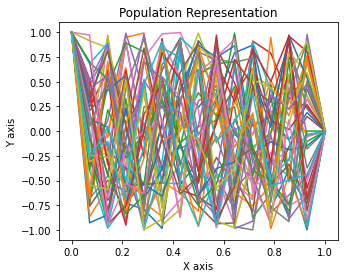


--------------------------------
Population Created
--------------------------------
Number of individuals:  50
Population Edited Parameters:  n_points=15__height=1__width=1
-------------------------------- 

Generation 0, current best = 2.624, current population size = 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


Generation 500, current best = 0.959, current population size = 50
Generation 1000, current best = 0.940, current population size = 50
Generation 1500, current best = 0.933, current population size = 50
Generation 2000, current best = 0.929, current population size = 50
Generation 2500, current best = 0.929, current population size = 50
Generation 3000, current best = 0.918, current population size = 50
Generation 3500, current best = 0.923, current population size = 50
Generation 4000, current best = 0.913, current population size = 50
Generation 4500, current best = 0.929, current population size = 50
Generation 5000, current best = 0.929, current population size = 50
Generation 5500, current best = 0.907, current population size = 50
Generation 6000, current best = 0.907, current population size = 50
Generation 6500, current best = 0.906, current population size = 50
Generation 7000, current best = 0.929, current population size = 50
Generation 7500, current best = 0.908, current po

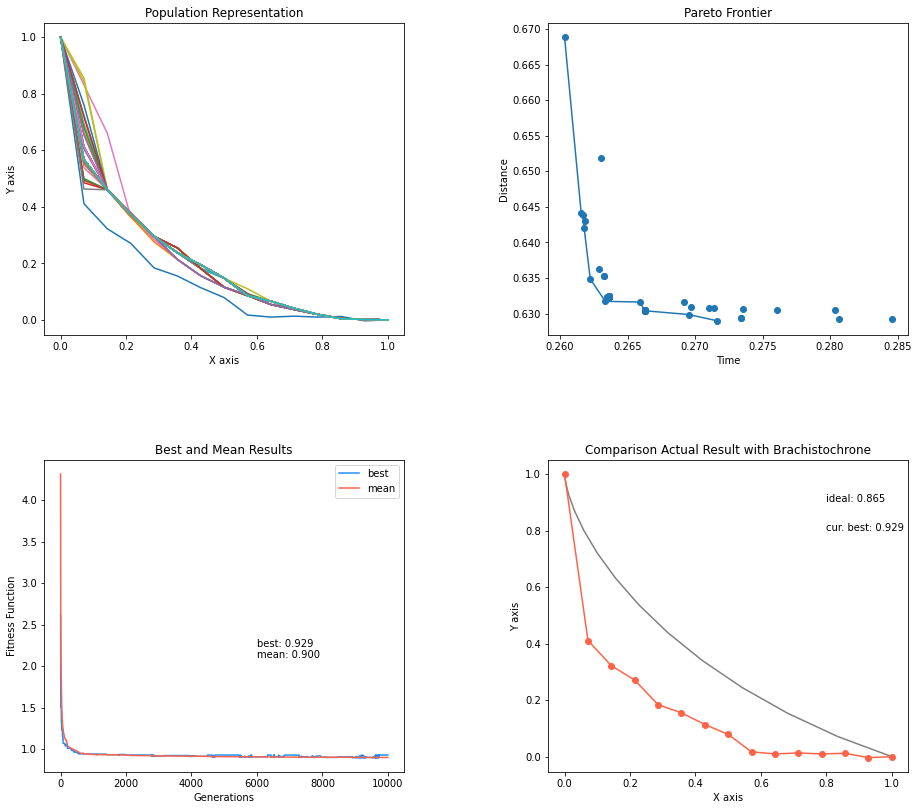

In [46]:
population = Population(Individual, 
                        n_individuals=ga_n_individuals, 
                        n_points=ga_n_points, 
                        height=ga_height, 
                        width=ga_width, 
                        show_plot=ga_show_plot, 
                        show_info=ga_show_info, 
                        show_debug=ga_show_debug)

GeneticAlgorithm(population=population,
                 n_generations=ga_n_generations,
                 objectives=ga_objectives,
                 ps=ga_ps,
                 pc=ga_pc,
                 pm=ga_pm,
                 show_plot=ga_show_plot, 
                 show_info=ga_show_info, 
                 show_debug=ga_show_debug)


## Population Generation from CSV points

In [ ]:
punti = [[[0,
 0.05263157894736842,
 0.10526315789473684,
 0.15789473684210525,
 0.21052631578947367,
 0.2631578947368421,
 0.3157894736842105,
 0.3684210526315789,
 0.42105263157894735,
 0.47368421052631576,
 0.5263157894736842,
 0.5789473684210527,
 0.631578947368421,
 0.6842105263157894,
 0.7368421052631579,
 0.7894736842105263,
 0.8421052631578947,
 0.894736842105263,
 0.9473684210526315,
 1],[1,
 0.6118913238837609,
 -0.44756237165565427,
 -0.8566023237391935,
 0.8818333939466898,
 -0.2538243070087751,
 -0.8881237925637497,
 0.14280941611953168,
 -0.87353253622443,
 0.7344300131776156,
 0.4290918622293318,
 -0.2540427834897594,
 -0.448473597582727,
 0.7981370476118044,
 -0.8044149731263508,
 -0.2822036557210994,
 -0.3757061957687715,
 -0.04080924796287877,
 -0.8562092507534942,
 0]], [[0,
 0.05263157894736842,
 0.10526315789473684,
 0.15789473684210525,
 0.21052631578947367,
 0.2631578947368421,
 0.3157894736842105,
 0.3684210526315789,
 0.42105263157894735,
 0.47368421052631576,
 0.5263157894736842,
 0.5789473684210527,
 0.631578947368421,
 0.6842105263157894,
 0.7368421052631579,
 0.7894736842105263,
 0.8421052631578947,
 0.894736842105263,
 0.9473684210526315,
 1],[1,
 0.6118913238837609,
 0.44756237165565427,
 0.8566023237391935,
 0.8818333939466898,
 0.2538243070087751,
 0.8881237925637497,
 0.14280941611953168,
 0.87353253622443,
 0.7344300131776156,
 0.4290918622293318,
 0.2540427834897594,
 0.448473597582727,
 0.7981370476118044,
 0.8044149731263508,
 0.2822036557210994,
 0.3757061957687715,
 0.04080924796287877,
 0.8562092507534942,
 0]]]

# Extra